# Semi-Supervised Learning approach

## Done by: Amrou CHOUCHENE - Wassim BOUATAY - Yassine NAJI

### import libraries

In [2]:
%matplotlib inline
import os
import struct
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torch.autograd import Variable
from torch.utils.data import TensorDataset,DataLoader
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
import time
import torchvision.transforms as transforms
from google.colab import drive
import h5py
import pandas as pd
from skimage import io
import seaborn as sns
import shutil
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score ,accuracy_score
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import Dataset
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
from xgboost import XGBClassifier
from tqdm import tqdm
from matplotlib import cm
import warnings
import random 
warnings.simplefilter("ignore")

### Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import h5py
path_file ='/content/drive/MyDrive' 
f_train = h5py.File(path_file + '/train_data_h.h5', 'r')
f_val = h5py.File(path_file + '/val_data_h.h5', 'r')
f_test = h5py.File(path_file + '/test_data_h.h5', 'r')

## Preprocessing clinical attributes data

In [50]:
path_data =  '/content/drive/My Drive/Challenge'
path_file = '/content/drive/My Drive/'
train_csv = pd.read_csv(path_data+"/trainset/trainset_true.csv")  
test_csv = pd.read_csv(path_data+"/testset/testset_data.csv") 

def csv_processing(features):
  def calculate_age(born):
    today = date.today()
    try:
      [day, month, year] = [int(i) for i in born.split("/")]
    except:
      [day, month, year] = [int(i) for i in born.split("-")]
    return today.year - year - ((today.month, today.day) < (month, day))

  features["DOB"] = features["DOB"].apply(calculate_age)
  features["GENDER"] = features["GENDER"].apply(lambda s:0 if s=='M' else 1)

  features["model_output"] = [0]*len(features)

  return features 

train_csv_preprocessed = csv_processing(train_csv)
test_csv_preprocessed = csv_processing(test_csv)
train_csv_preprocessed

,ID,LABEL,GENDER,DOB,LYMPH_COUNT,model_output
0,P26,1,0,88,11.20,0
1,P183,1,0,78,12.80,0
2,P89,1,0,85,9.60,0
3,P123,1,0,89,122.60,0
4,P61,1,1,89,11.60,0
...,...,...,...,...,...,...
158,P135,1,0,69,9.45,0
159,P8,0,0,45,4.91,0
160,P130,0,1,77,4.17,0
161,P70,1,0,33,5.66,0


### Construct ALL-IDB2 training and validation set

In [6]:


# First 200 images are used for training and the remaining 60 for testing
Datapath = '/content/drive/My Drive/ALL_IDB2/img/'
listing = os.listdir(Datapath)
# ALL_IDB2 dataset has 260 images in total
img_size = 130
TrainImages = torch.FloatTensor(400,3,img_size,img_size)
TrainLabels = torch.LongTensor(400)
TestImages = torch.FloatTensor(60,3,img_size,img_size)
TestLabels = torch.LongTensor(60)
img_no = 0
for file in listing:
    im=Image.open(Datapath + file)
    im = im.resize((img_size,img_size))
    im = np.array(im)   

    if img_no < 100 :
        im = torch.from_numpy(im / 255.0).transpose(0,2)
        #im = transforms.Normalize(mean=[mean0, mean1, mean2], std=[std0, std1,std2])(im)
        TrainImages[img_no] = im.unsqueeze(0)
        TrainLabels[img_no] = int(listing[img_no][6:7])
    elif img_no <160:
        im = torch.from_numpy(im / 255.0).transpose(0,2)
        #im = transforms.Normalize(mean=[mean0, mean1, mean2], std=[std0, std1,std2])(im)
        TestImages[img_no - 100] = im.unsqueeze(0)
        TestLabels[img_no - 100] = int(listing[img_no][6:7])
    else:
        im = torch.from_numpy(im / 255.0).transpose(0,2)
        #im = transforms.Normalize(mean=[mean0, mean1, mean2], std=[std0, std1,std2])(im)
        TrainImages[img_no - 60] = im.unsqueeze(0)
        TrainLabels[img_no - 60] = int(listing[img_no][6:7])
    img_no = img_no + 1

In [7]:
mean0 = float(TrainImages[:200 ,0 , :, :].mean())
mean1 = float(TrainImages[:200 ,1 , :, :].mean())
mean2 = float(TrainImages[:200 ,2 , :, :].mean())

std0 = float(TrainImages[:200 ,0 , :, :].std())
std1 = float(TrainImages[:200 ,1 , :, :].std())
std2 = float(TrainImages[:200 ,2 , :, :].std())

### Visualizing ALL-IDB2 sample

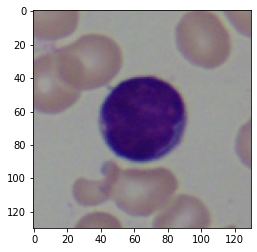

In [9]:
plt.imshow( TrainImages[0].transpose(0,2) )

### Visualizing our Kaggle challenge's images

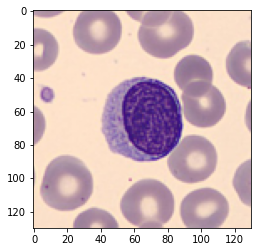

In [10]:
im = f_train['P0'][0]
im = Image.fromarray(np.uint8(im)).convert('RGB')
im = im.resize((img_size,img_size))
im = np.array(im) / 255 

im = torch.from_numpy(im ).transpose(0,2)
plt.imshow(im.permute(1,2,0))


### Preprocessing our kaggle challenge's images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


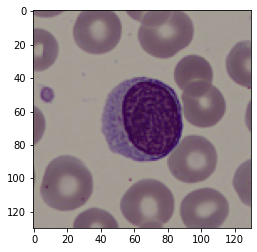

In [11]:
im = f_train['P0'][0]
im = Image.fromarray(np.uint8(im)).convert('RGB')
im = im.resize((img_size,img_size))
im = np.array(im) / 255 

im[:,:,0] = mean0 + (im[:,:,0] - im[:,:,0].mean() ) * std0 /  im[:,:,0].std()
im[:,:,1] = mean1 + (im[:,:,1] - im[:,:,1].mean() ) * std1 /  im[:,:,1].std()
im[:,:,2] = mean2 + (im[:,:,2] - im[:,:,2].mean() ) * std2 /  im[:,:,2].std()
im = torch.from_numpy(im).transpose(0,2).unsqueeze(0)


      
#im = transforms.Normalize(mean=[mean0, mean1, mean2], std=[std0, std1,std2])(im)
plt.imshow(im.squeeze(0).permute(1,2,0))


### Creating datasets and dataloaders

In [12]:
# Creating pytorch dataset
trainDataset = TensorDataset(TrainImages, TrainLabels)
testDataset = TensorDataset(TestImages, TestLabels)
# Creating dataloader
BatchSize = 1
trainLoader = DataLoader(trainDataset, batch_size=BatchSize, shuffle=True,num_workers=4, pin_memory=True)
testLoader = DataLoader(testDataset, batch_size=BatchSize, shuffle=True,num_workers=4, pin_memory=True)

In [13]:
# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')

GPU is available!


### Initialize the network

In [14]:
'''# AlexNet
net = models.alexnet(pretrained=True)
new_classifier = nn.Sequential(*list(net.classifier.children())[:-1])
new_classifier.add_module('fc',nn.Linear(4096,2))
new_classifier.add_module('softmax',nn.LogSoftmax())
net.classifier = new_classifier
print(net)
if use_gpu:
    net = net.cuda()

# Resnet18
net = models.resnet18(pretrained=True)
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 2)
print(net)
if use_gpu:
    net = net.cuda()

# Inceptionv3
net = models.inception_v3(pretrained=True)
num_ftrs1 = net.fc.in_features
num_ftrs2 = net.AuxLogits.fc.in_features
net.AuxLogits.fc = nn.Linear(num_ftrs2,2)
net.fc = nn.Linear(num_ftrs1,2)
net.add_module('softmax',nn.LogSoftmax())
net.AuxLogits.add_module('softmax',nn.LogSoftmax())
print(net)
if use_gpu:
    net = net.cuda()'''

# VGG19
net = models.vgg19(pretrained=True)
num_ftrs = net.classifier[6].in_features
new_classifier = nn.Sequential(*list(net.classifier.children())[:-1])
new_classifier.add_module('fc',nn.Linear(num_ftrs,2))
new_classifier.add_module('softmax',nn.LogSoftmax())
net.classifier = new_classifier
print(net)
if use_gpu:
    net = net.cuda()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pad

### Define loss function and optimizer: 

In [15]:
criterion = nn.NLLLoss() # Negative Log-Likelihood
 
#weight = torch.tensor([0.9 , 0.1 ]).cuda()
#criterion = nn.CrossEntropyLoss(weight)  
optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9) # Stochastic gradient descent

## Train the network - ALL-IDB2 classification

At Iteration: 1 /12  ;  Training Loss: 0.601899 ; Testing Acc: 95.000 ; Time consumed: 0m 9s 
At Iteration: 2 /12  ;  Training Loss: 0.339139 ; Testing Acc: 95.000 ; Time consumed: 0m 9s 
At Iteration: 3 /12  ;  Training Loss: 0.277331 ; Testing Acc: 90.000 ; Time consumed: 0m 9s 
At Iteration: 4 /12  ;  Training Loss: 0.094529 ; Testing Acc: 95.000 ; Time consumed: 0m 9s 
At Iteration: 5 /12  ;  Training Loss: 0.006634 ; Testing Acc: 93.333 ; Time consumed: 0m 9s 
At Iteration: 6 /12  ;  Training Loss: 0.001585 ; Testing Acc: 95.000 ; Time consumed: 0m 9s 
At Iteration: 7 /12  ;  Training Loss: 0.001708 ; Testing Acc: 93.333 ; Time consumed: 0m 9s 
At Iteration: 8 /12  ;  Training Loss: 0.000756 ; Testing Acc: 93.333 ; Time consumed: 0m 9s 
At Iteration: 9 /12  ;  Training Loss: 0.000470 ; Testing Acc: 93.333 ; Time consumed: 0m 9s 
At Iteration: 10 /12  ;  Training Loss: 0.000269 ; Testing Acc: 93.333 ; Time consumed: 0m 9s 
At Iteration: 11 /12  ;  Training Loss: 0.000285 ; Testing 

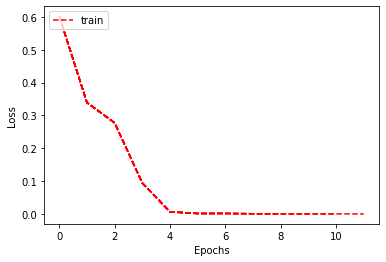

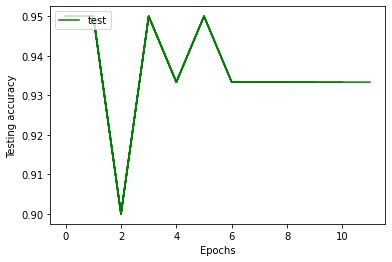

In [16]:
iterations = 10

def train(net , TrainImages ,TrainLabels , TestImages , TestLabels , nb_samples = 200 , iterations = 10 , plot = 1):
  trainLoss = []
  testAcc = []
  trainDataset = TensorDataset(TrainImages[:nb_samples,:,:,:], TrainLabels[:nb_samples])
  
  
  testDataset = TensorDataset(TestImages, TestLabels)
  # Creating dataloader
  BatchSize = 1
  trainLoader = DataLoader(trainDataset, batch_size=BatchSize, shuffle=True,num_workers=4, pin_memory=True)
  testLoader = DataLoader(testDataset, batch_size=BatchSize, shuffle=True,num_workers=4, pin_memory=True)
  #print(len(trainLoader))
  #print(len(testLoader))
  start = time.time()
  for epoch in range(iterations):
      epochStart = time.time()
      runningLoss = 0    
      net.train(True) # For training
      for data in trainLoader:
          inputs,labels = data
          # Wrap them in Variable
          if use_gpu:
              inputs, labels = Variable(inputs.float().cuda()), \
                  Variable(labels.long().cuda())
          else:
              inputs, labels = Variable(inputs), Variable(labelslong()) 
          #inputs = inputs/255.0
          # Initialize gradients to zero
          optimizer.zero_grad()
          # Feed-forward input data through the network
          outputs = net(inputs)
          # Compute loss/error
          loss = criterion(outputs, labels) 
              
          # Backpropagate loss and compute gradients
          loss.backward()
          # Update the network parameters
          optimizer.step()
          # Accumulate loss per batch
          runningLoss += loss.item()   
      avgTrainLoss = runningLoss/len(TrainLabels[:nb_samples])
      trainLoss.append(avgTrainLoss)
      torch.cuda.empty_cache()
      # Evaluating performance on test set for each epoch
      net.train(False) # For testing
      #inputs = TestImages/255
      inputs = TestImages
      if use_gpu:
          inputs = Variable(inputs.cuda())
          outputs = net(inputs)
          _, predicted = torch.max(outputs.data, 1)
          predicted = predicted.cpu()
      else:
          inputs = Variable(inputs)
          outputs = net(inputs)
          _, predicted = torch.max(outputs.data, 1)

      correct = 0
      total = 0
      total += TestLabels.size(0)
      correct += (predicted == TestLabels).sum()
      avgTestAcc = correct/len(TestLabels)
      testAcc.append(avgTestAcc)
      best_accuracy= 0
          
      # Plotting Loss vs Epochs
      if plot==1:
        fig1 = plt.figure(1)        
        plt.plot(range(epoch+1),trainLoss,'r--',label='train')        
      if epoch==0 and plot==1:
          plt.legend(loc='upper left')
          plt.xlabel('Epochs')
          plt.ylabel('Loss')    
      # Plotting testing accuracy vs Epochs
      if plot==1:
        fig2 = plt.figure(2)        
        plt.plot(range(epoch+1),testAcc,'g-',label='test')    
      '''if avgTestAcc > best_accuracy:
        best_accuracy =  avgTestAcc
        torch.save(net, '/content/drive/MyDrive/model_ALL_IDB2.pt')  '''
      if epoch==0 and plot==1:
          plt.legend(loc='upper left')
          plt.xlabel('Epochs')
          plt.ylabel('Testing accuracy')   
      epochEnd = time.time()-epochStart
      print('At Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f} ; Testing Acc: {:.3f} ; Time consumed: {:.0f}m {:.0f}s '\
              .format(epoch + 1,iterations,avgTrainLoss,avgTestAcc*100,epochEnd//len(TestLabels),epochEnd%len(TestLabels)))
      torch.cuda.empty_cache()
      
  end = time.time()-start
  if plot==1:
    print('Training completed in {:.0f}m {:.0f}s'.format(end//len(TestLabels),end%len(TestLabels)))
  return net

model = train( net , TrainImages ,TrainLabels , TestImages , TestLabels , nb_samples = 200 , iterations = 12 , plot = 1 )

### Constructing preprocessed images dataset

In [18]:
patients_images_preprocessed= dict()
for patient in list( f_train.keys() ):
  L = []
  for im in f_train[patient]:
    im = Image.fromarray(np.uint8(im)).convert('RGB')
    im = im.resize((img_size,img_size))
    im = np.array(im) / 255.0 
    im[:,:,0] = mean0 + (im[:,:,0] - im[:,:,0].mean() ) * std0 /  im[:,:,0].std()
    im[:,:,1] = mean1 + (im[:,:,1] - im[:,:,1].mean() ) * std1 /  im[:,:,1].std()
    im[:,:,2] = mean2 + (im[:,:,2] - im[:,:,2].mean() ) * std2 /  im[:,:,2].std()
    im = torch.from_numpy(im).transpose(0,2).unsqueeze(0)
    L.append(im)
  patients_images_preprocessed[patient] = L



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
tensor([[-5.4735e+00, -4.2054e-03]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)


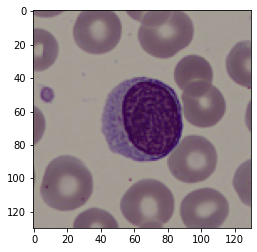

In [19]:
im = patients_images_preprocessed['P0'][0]

inputs = im.type(torch.FloatTensor)
plt.imshow(inputs.squeeze(0).permute(1,2,0))
print(type(inputs))
inputs = Variable( inputs.cuda() )
outputs = model(inputs)
print(outputs)

### Semi-Supervised learning: predict the positive labels

In [20]:


patients0 = []
patients1 = []
visited = dict()
d_nb = dict()
patients = list(f_train.keys())
for j in range( len(patients)):
  patient = patients[j]
  d_nb[patient] = 5
  target = int(train_csv_preprocessed.loc[train_csv_preprocessed["ID"]==patients[j]]['LABEL'])
  if target==1:
    patients1.append(patients[j])
  else:
    patients0.append(patients[j])



nb = 0
for i in range(23):
  net = models.vgg16(pretrained=True)
  num_ftrs = net.classifier[6].in_features
  new_classifier = nn.Sequential(*list(net.classifier.children())[:-1])
  new_classifier.add_module('fc',nn.Linear(num_ftrs,2))
  new_classifier.add_module('softmax',nn.LogSoftmax())
  net.classifier = new_classifier
  net = net.cuda()
  criterion = nn.NLLLoss() # Negative Log-Likelihood
  #weight = torch.tensor([0.9 , 0.1 ]).cuda()
  #criterion = nn.CrossEntropyLoss(weight)  
  optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9)
  print("**************iteration: {}**********************".format(i+1))
  print("nb = " , nb)
  model = train( net , TrainImages ,TrainLabels , TestImages , TestLabels , nb_samples = 200 + nb  , iterations = 10 , plot = 0 )
  L = []
  if i < 5:
    
    for j in range( len(patients1)):
      patient = patients1[j]
      Datapath =  '/content/drive/My Drive/Challenge/trainset/' + patient
      listing = os.listdir(Datapath)
      for k in range( len(f_train[patient])):  
          im = patients_images_preprocessed[patient][k]
          inputs = im.type(torch.FloatTensor)
          inputs = inputs.cuda()
          outputs = model(inputs)
          _, predicted =  torch.max(outputs.data, 1) 
          if int(predicted)==1:
            L.append((float (outputs[0][1]) , patient , k ) )
    L = sorted(L, reverse=True)
    print("L : " , L)
    for j in range(len(L)):
      ch = L[j][1] + '{}'.format(L[j][2])
      if ch not in visited.keys() and d_nb[L[j][1]] >0:
        d_nb[L[j][1]] -= 1
        visited[ch] = 1
        im = patients_images_preprocessed[L[j][1]][L[j][2]]
        TrainImages[200+nb] = im
        TrainLabels[200+nb] = 1
        nb += 1
        while True:
          ind_patient0 = random.randint(0,len(patients0) - 1)
          ind_image = random.randint(0, len( f_train[patients0[ind_patient0] ] ) - 1)
          ch = patients0[ind_patient0] + '{}'.format(ind_image)
          if ch not in visited.keys():
              TrainImages[200 + nb] = patients_images_preprocessed[patients0[ind_patient0]][ind_patient0]
              TrainLabels[200+nb] = 0
              nb +=1
              visited[ch] = 1
              break

        if nb%4==0 and nb!=0:
          print('visited : ', visited )
          break

  else:
    for j in range( len(patients1)):
      patient = patients1[j]
      Datapath =  '/content/drive/My Drive/Challenge/trainset/' + patient
      listing = os.listdir(Datapath)
      for k in range( len(f_train[patient])):  
          im = patients_images_preprocessed[patient][k]
          inputs = im.type(torch.FloatTensor)
          inputs = inputs.cuda()
          outputs = model(inputs)
          _, predicted =  torch.max(outputs.data, 1) 
          if int(predicted)==1:
            L.append((float (outputs[0][1]) , patient , k ) )

    L = sorted(L, reverse=True)
    print("L : " , L)
    for j in range(len(L)):
      ch = L[j][1] + '{}'.format(L[j][2])
      if ch not in visited.keys() and d_nb[L[j][1]] >0 :
        d_nb[L[j][1]] -= 1
        visited[ch] = 1
        im = patients_images_preprocessed[L[j][1]][L[j][2]]
        TrainImages[200+nb] = im
        TrainLabels[200+nb] = 1
        nb += 1
        while True:
          ind_patient0 = random.randint(0,len(patients0) - 1)
          ind_image = random.randint(0, len( f_train[patients0[ind_patient0] ] ) - 1)
          ch = patients0[ind_patient0] + '{}'.format(ind_image)
          if ch not in visited.keys():
              TrainImages[200 + nb] = patients_images_preprocessed[patients0[ind_patient0]][ind_patient0]
              TrainLabels[200+nb] = 0
              nb +=1
              visited[ch] = 1
              break
          
        if nb%10==0 and nb!=0:
          print('visited : ', visited )
          break  
  
 






86
44


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



**************iteration: 1**********************
nb =  0
At Iteration: 1 /10  ;  Training Loss: 0.584264 ; Testing Acc: 91.667 ; Time consumed: 0m 9s 
At Iteration: 2 /10  ;  Training Loss: 0.333204 ; Testing Acc: 91.667 ; Time consumed: 0m 9s 
At Iteration: 3 /10  ;  Training Loss: 0.218424 ; Testing Acc: 90.000 ; Time consumed: 0m 9s 
At Iteration: 4 /10  ;  Training Loss: 0.093685 ; Testing Acc: 91.667 ; Time consumed: 0m 9s 
At Iteration: 5 /10  ;  Training Loss: 0.099172 ; Testing Acc: 93.333 ; Time consumed: 0m 9s 
At Iteration: 6 /10  ;  Training Loss: 0.036516 ; Testing Acc: 93.333 ; Time consumed: 0m 9s 
At Iteration: 7 /10  ;  Training Loss: 0.002974 ; Testing Acc: 93.333 ; Time consumed: 0m 9s 
At Iteration: 8 /10  ;  Training Loss: 0.001279 ; Testing Acc: 93.333 ; Time consumed: 0m 9s 
At Iteration: 9 /10  ;  Training Loss: 0.000682 ; Testing Acc: 93.333 ; Time consumed: 0m 9s 
At Iteration: 10 /10  ;  Training Loss: 0.000722 ; Testing Acc: 93.333 ; Time consumed: 0m 9s 
L

### Visualize some positive predicted samples by the Semi-Supervised learning approach

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


180
180
20
20
label:  tensor(1)


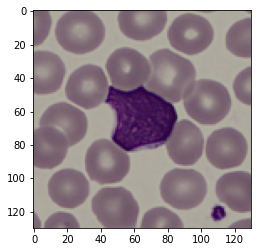

label:  tensor(0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


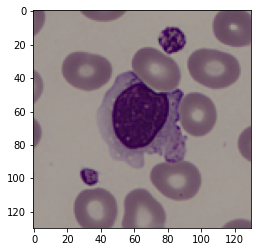

label:  tensor(1)


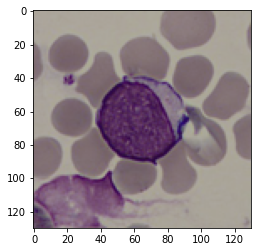

label:  tensor(0)


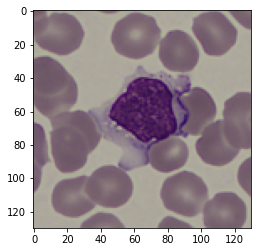

label:  tensor(1)


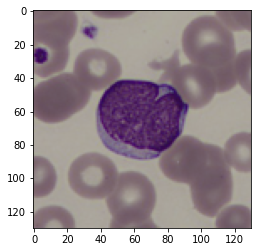

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  tensor(0)


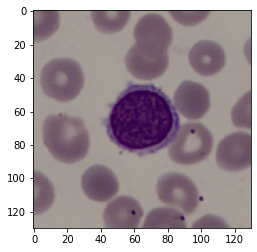

In [22]:
TrainImagesNew = TrainImages[200:380]
TrainLabelsNew = TrainLabels[200:380]
TestImagesNew = TrainImages[380:]
TestLabelsNew = TrainLabels[380:]

print(len(TrainImagesNew) )
print(len(TrainLabelsNew) )
print(len(TestImagesNew) )
print(len(TestLabelsNew) )
for i in range(6):
  print('label: ',TrainLabelsNew[i])
  plt.imshow(TrainImagesNew[i].squeeze(0).permute(1,2,0))
  plt.show()

### Training an instance-level model  

At Iteration: 1 /10  ;  Training Loss: 0.499016 ; Testing Acc: 95.000 ; Time consumed: 0m 7s 
At Iteration: 2 /10  ;  Training Loss: 0.141716 ; Testing Acc: 95.000 ; Time consumed: 0m 7s 
At Iteration: 3 /10  ;  Training Loss: 0.120247 ; Testing Acc: 100.000 ; Time consumed: 0m 7s 
At Iteration: 4 /10  ;  Training Loss: 0.010199 ; Testing Acc: 95.000 ; Time consumed: 0m 7s 
At Iteration: 5 /10  ;  Training Loss: 0.000777 ; Testing Acc: 100.000 ; Time consumed: 0m 7s 
At Iteration: 6 /10  ;  Training Loss: 0.000341 ; Testing Acc: 100.000 ; Time consumed: 0m 7s 
At Iteration: 7 /10  ;  Training Loss: 0.000263 ; Testing Acc: 100.000 ; Time consumed: 0m 7s 
At Iteration: 8 /10  ;  Training Loss: 0.000216 ; Testing Acc: 100.000 ; Time consumed: 0m 7s 
At Iteration: 9 /10  ;  Training Loss: 0.000217 ; Testing Acc: 100.000 ; Time consumed: 0m 7s 
At Iteration: 10 /10  ;  Training Loss: 0.000108 ; Testing Acc: 100.000 ; Time consumed: 0m 7s 
Training completed in 3m 12s


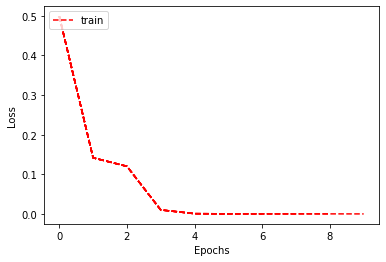

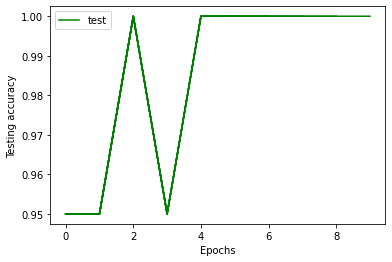

In [23]:
net = models.vgg16(pretrained=True)
num_ftrs = net.classifier[3].in_features
new_classifier = nn.Sequential(*list(net.classifier.children())[:-4])
new_classifier.add_module('fc',nn.Linear(num_ftrs,2))
new_classifier.add_module('softmax',nn.LogSoftmax())
net.classifier = new_classifier
net = net.cuda()

criterion = nn.NLLLoss() # Negative Log-Likelihood
#weight = torch.tensor([0.9 , 0.1 ]).cuda()
#criterion = nn.CrossEntropyLoss(weight)  
optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9)

model = train( net , TrainImagesNew ,TrainLabelsNew , TestImagesNew , TestLabelsNew , nb_samples = len(TrainLabelsNew)  , iterations = 10 , plot = 1 )

### Construct xgboost's input matrix

In [24]:
X_train = np.zeros((len(f_train) , 4) )
X_val = np.zeros((len(f_val) , 4))
X_test = np.zeros((len(f_test) , 4))
y_train = np.zeros(len(f_train))
y_val = np.zeros(len(f_val))
y_test = np.zeros(len(f_test))

In [26]:
patients = list(f_train.keys())


for j in range( len(patients)):
  patient = patients[j]
  Datapath =  '/content/drive/My Drive/Challenge/trainset/' + patient
  listing = os.listdir(Datapath)
  tImages = torch.FloatTensor(len(f_train[patient]),3,img_size,img_size)
  i = 0
  for im in f_train[patient]:  
      im = Image.fromarray(np.uint8(im)).convert('RGB')
      im = im.resize((img_size,img_size))
      im = np.array(im) / 255.0 
      im[:,:,0] = mean0 + (im[:,:,0] - im[:,:,0].mean() ) * std0 /  im[:,:,0].std()
      im[:,:,1] = mean1 + (im[:,:,1] - im[:,:,1].mean() ) * std1 /  im[:,:,1].std()
      im[:,:,2] = mean2 + (im[:,:,2] - im[:,:,2].mean() ) * std2 /  im[:,:,2].std()
      im = torch.from_numpy(im).transpose(0,2).unsqueeze(0)
      tImages[i] = im
      i +=1

  inputs = tImages
  inputs = Variable(inputs.cuda())
  outputs = model(inputs)
  _, predicted = torch.max(outputs.data, 1)
  torch.cuda.empty_cache()
  target = torch.tensor(int(train_csv_preprocessed.loc[train_csv_preprocessed["ID"]==patient]['LABEL']))
  X_train[j][3] = int(train_csv_preprocessed.loc[train_csv_preprocessed["ID"]==patient]['DOB'])
  X_train[j][0] = float(train_csv_preprocessed.loc[train_csv_preprocessed["ID"]==patient]['LYMPH_COUNT'])
  X_train[j][1] = float( predicted.sum() )
  X_train[j][2] =  len(predicted) - float( predicted.sum() )
  y_train[j] = int(train_csv_preprocessed.loc[train_csv_preprocessed["ID"]==patient]['LABEL'])

  
  

  predicted = predicted.cpu()
  print('patient: {} , target {}'.format(patient,int(target)) )
  print(predicted)
  

patient: P0 , target 1
tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0])
patient: P1 , target 1
tensor([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0])
patient: P10 , target 0
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
patient: P100 , target 1
tensor([0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0])
patient: P101 , target 0
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0

In [27]:
patients = list(f_val.keys())

for j in range( len(patients)):
  patient = patients[j]
  Datapath =  '/content/drive/My Drive/Challenge/trainset/' + patient
  listing = os.listdir(Datapath)
  vImages = torch.FloatTensor(len(f_val[patient]),3,img_size,img_size)
  i = 0
  for im in f_val[patient]:
      im = Image.fromarray(np.uint8(im)).convert('RGB')
      im = im.resize((img_size,img_size))
      im = np.array(im) / 255.0 
      im[:,:,0] = mean0 + (im[:,:,0] - im[:,:,0].mean() ) * std0 /  im[:,:,0].std()
      im[:,:,1] = mean1 + (im[:,:,1] - im[:,:,1].mean() ) * std1 /  im[:,:,1].std()
      im[:,:,2] = mean2 + (im[:,:,2] - im[:,:,2].mean() ) * std2 /  im[:,:,2].std()
      im = torch.from_numpy(im).transpose(0,2).unsqueeze(0)
      vImages[i] = im
      i +=1
  inputs = vImages
  inputs = Variable(inputs.cuda())
  outputs = model(inputs)
  _, predicted = torch.max(outputs.data, 1)
  torch.cuda.empty_cache()
  target = torch.tensor(int(train_csv_preprocessed.loc[train_csv_preprocessed["ID"]==patient]['LABEL']))
  X_val[j][3] = int(train_csv_preprocessed.loc[train_csv_preprocessed["ID"]==patient]['DOB'])
  X_val[j][0] = float(train_csv_preprocessed.loc[train_csv_preprocessed["ID"]==patient]['LYMPH_COUNT'])
  X_val[j][1] = float( predicted.sum() )
  X_val[j][2] =  len(predicted) - float( predicted.sum() )
  y_val[j] = int(train_csv_preprocessed.loc[train_csv_preprocessed["ID"]==patient]['LABEL'])
  
  

  predicted = predicted.cpu()
  print('patient: {} , target {}'.format(patient,int(target)) )
  print(predicted)

patient: P102 , target 1
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 0])
patient: P116 , target 1
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
patient: P118 , target 1
tensor([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1])
patient: P122 , target 1
tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

In [28]:
patients = list(f_test.keys())

for j in range( len(patients)):
  patient = patients[j]
  Datapath =  '/content/drive/My Drive/Challenge/testset/' + patient
  listing = os.listdir(Datapath)
  teImages = torch.FloatTensor(len(f_test[patient]),3,img_size,img_size)
  i = 0
  for im in f_test[patient]:
      im = Image.fromarray(np.uint8(im)).convert('RGB')
      im = im.resize((img_size,img_size))
      im = np.array(im) / 255.0 
      im[:,:,0] = mean0 + (im[:,:,0] - im[:,:,0].mean() ) * std0 /  im[:,:,0].std()
      im[:,:,1] = mean1 + (im[:,:,1] - im[:,:,1].mean() ) * std1 /  im[:,:,1].std()
      im[:,:,2] = mean2 + (im[:,:,2] - im[:,:,2].mean() ) * std2 /  im[:,:,2].std()
      im = torch.from_numpy(im).transpose(0,2).unsqueeze(0)
      teImages[i] = im
      i +=1
 
  inputs = teImages
  inputs = Variable(inputs.cuda())
  outputs = model(inputs)
  _, predicted = torch.max(outputs.data, 1)
  torch.cuda.empty_cache()
  target = torch.tensor(int(test_csv_preprocessed.loc[test_csv_preprocessed["ID"]==patient]['LABEL']))
  X_test[j][3] = int(test_csv_preprocessed.loc[test_csv_preprocessed["ID"]==patient]['DOB'])
  X_test[j][0] = float(test_csv_preprocessed.loc[test_csv_preprocessed["ID"]==patient]['LYMPH_COUNT'])
  X_test[j][1] = float( predicted.sum() )
  X_test[j][2] =  len(predicted) - float( predicted.sum() )
  y_test[j] = int(test_csv_preprocessed.loc[test_csv_preprocessed["ID"]==patient]['LABEL'])
  
  

  predicted = predicted.cpu()
  print('patient: {} , target {}'.format(patient,int(target)) )
  print(predicted)

patient: P108 , target -1
tensor([0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])
patient: P114 , target -1
tensor([0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
patient: P119 , target -1
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
patient: P120 , target -1
tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,

### xgboost classifier

In [47]:
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score, f1_score , precision_score, recall_score

xgb = XGBClassifier( learning_rate=0.09 , n_estimators=50 , n_jobs=-1 , verbosity=0)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)
print("Balanced_Accuracy =", balanced_accuracy_score(y_val, y_pred))
print("f1_score =", f1_score(y_val, y_pred))
print("precision_score =", precision_score(y_val, y_pred))
print("recall_score =", recall_score(y_val, y_pred))

Balanced_Accuracy = 0.962962962962963
f1_score = 0.9615384615384615
precision_score = 1.0
recall_score = 0.9259259259259259


In [48]:
y_test = xgb.predict(X_test)
y_test

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 0., 1., 1., 1., 0.])

### Submission file

In [49]:
output_file = open('kaggle_submission.csv', "w")
output_file.write("ID,Predicted\n")
patients = list(f_test.keys())
for i in range(len(patients)):
    output_file.write("%s,%d\n" % (patients[i], y_test[i]))

output_file.close()